In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import math

class Value:
    
    def __init__(self, data=0, data_children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = data_children
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
            
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward             

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self, other), '-')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad -= 1.0 * out.grad
        out._backward = _backward
    
        return out

 
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
                
        build_topo(self)
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()


In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" %(n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
        
    return dot

In [7]:
#inputs 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'


x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
# -----
e = (2 * n).exp()
o = (e-1)/(e+1)
#------
o.label = 'o'
o.backward()



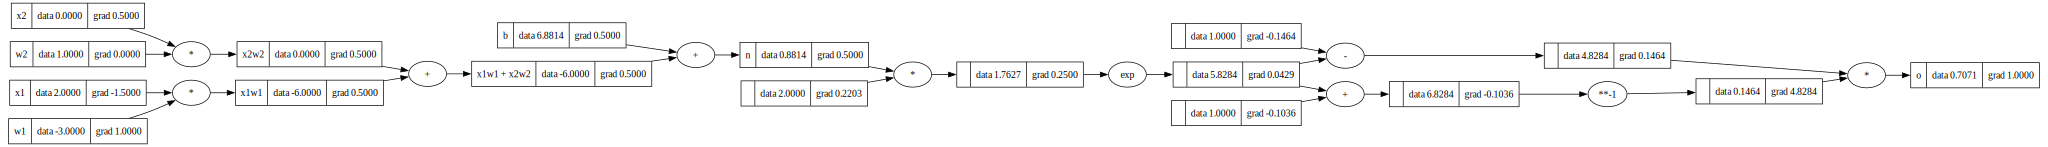

In [8]:
draw_dot(o)


In [9]:
# o.grad = 1.0

In [ ]:
# 1-o.data**2

In [ ]:
# n.grad = 0.5

In [ ]:
# b.grad = 0.5

In [ ]:
# x1w1x2w2.grad = 0.5

In [ ]:
# x1w1.grad = 0.5

In [ ]:
# x2w2.grad = 0.5

In [ ]:
# x1.grad  =  w1.data * x1w1.grad
# w1.grad  =  x1.data * x1w1.grad

In [ ]:
# x2.grad  =  w2.data * x2w2.grad
# w2.grad  =  x2.data * x2w2.grad

In [ ]:
import torch

In [ ]:
x1 = torch.tensor([2.0]).double()            ;x1.requires_grad = True
x2 = torch.tensor([0.0]).double()            ;x2.requires_grad = True
w1 = torch.tensor([-3.0]).double()           ;w1.requires_grad = True
w2 = torch.tensor([1.0]).double()            ;w2.requires_grad = True
b  = torch.tensor([6.88137358]).double()     ;b.requires_grad = True
n = x1w1 + x2w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print('___')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1', x1.grad.item())
print('w2', x2.grad.item())


In [11]:
class neuron:
    def __init__(self,nin):
        self.w = (Value.random.uniform(-1,1) for _ in range(nin))
        self.b = (Value.random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b)
        out = act.tanh()
        return out
    
class layer:
    def __init__(self,nin,nout):
        self.neurons = [neurons(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:
    def __init_(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range (len(nouts))]
        
    def __call__(self,x)
        for layer in self.layers:
            x = layer(x)
        return x

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

SyntaxError: expected ':' (1050456932.py, line 24)

In [10]:
draw_dot(n(x))

NameError: name 'x' is not defined